In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as atu
from analyze_tools.monte_carlo import get_colliding_time

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average


In [2]:
20 * red.boltzmann / red.epsilon

0.16695708068580803

In [27]:
np.random.seed(10)

Lxy = 3e7; Lz = 3e3
T = 135

atoms = AtomsInBox(
    Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
    mass_dict = red.mass_dict)

v_ar = np.sqrt((T * red.boltzmann / red.epsilon) )
v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

atoms.add(
        elements = ["Ar"],
        r = np.array([[0.0, 0, -6/2]]),
        r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
        )

atoms.add(
        elements = ["Xe"],
        r = np.array([[0.0,0.0,6/2]]),
        r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
        )

idxAr = atoms.element_idx(element = "Ar")
idxXe = atoms.element_idx(element = "Xe")
epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)

# calculator to the atoms object
atoms.add_calculator(
    calculator_class = Calculator,
    calculator_kwargs = {
        "epsilon": epsilon_mat, "sigma" : sigma_mat, 
        "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
        "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
    })

atoms.update_distance()

In [28]:
k_vector_int = np.array(
    [[i,0,0] for i in range(1,100)]
    ,dtype=np.float64)

Afield = CavityVectorPotential(
    k_vector_int = k_vector_int, amplitude = 'boltzmann',
    Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = 20 * Lxy , T = T / red.temp
    )

In [29]:
t, rd = single_collision_simulation(
    0, h = 1e-2, atoms = atoms, field = Afield, potential_threshold = 1e-4,
    max_steps = 10000, verbose = True, record_every = 1)

Cycle: 0, iterations: 1, potential: -2.0806E-04
Cycle: 0, iterations: 2, potential: -2.1153E-04
Cycle: 0, iterations: 3, potential: -2.1507E-04
Cycle: 0, iterations: 4, potential: -2.1868E-04
Cycle: 0, iterations: 5, potential: -2.2235E-04
Cycle: 0, iterations: 6, potential: -2.2610E-04
Cycle: 0, iterations: 7, potential: -2.2993E-04
Cycle: 0, iterations: 8, potential: -2.3383E-04
Cycle: 0, iterations: 9, potential: -2.3780E-04
Cycle: 0, iterations: 10, potential: -2.4186E-04
Cycle: 0, iterations: 11, potential: -2.4600E-04
Cycle: 0, iterations: 12, potential: -2.5022E-04
Cycle: 0, iterations: 13, potential: -2.5452E-04
Cycle: 0, iterations: 14, potential: -2.5891E-04
Cycle: 0, iterations: 15, potential: -2.6339E-04
Cycle: 0, iterations: 16, potential: -2.6796E-04
Cycle: 0, iterations: 17, potential: -2.7262E-04
Cycle: 0, iterations: 18, potential: -2.7738E-04
Cycle: 0, iterations: 19, potential: -2.8224E-04
Cycle: 0, iterations: 20, potential: -2.8719E-04
Cycle: 0, iterations: 21, pot

In [30]:
atoms = rd['atoms']
field = rd['field']

field_energy = np.sum(np.array(field.history['energy']),axis = 1)
time_axis = field.history['t']

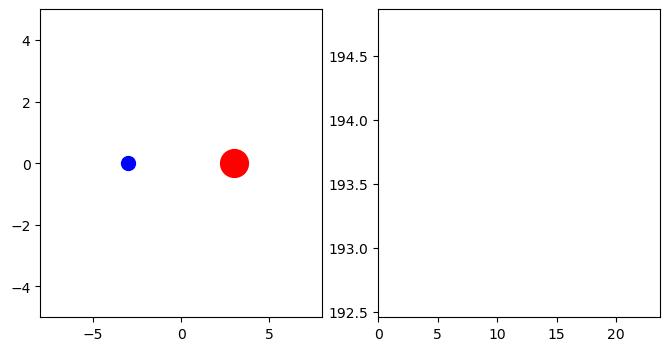

In [31]:
import matplotlib.animation as animation

fig, ax = plt.subplots( 1,2 , figsize = (8,4))

traj_len = len(atoms.trajectory['r']) - 1000

x_ar0 = atoms.trajectory['r'][0][0]
x_xe0 = atoms.trajectory['r'][0][1]

ar_scat, = ax[0].plot(x_ar0[2], x_ar0[0], 'bo', markersize = 10)
xe_scat, = ax[0].plot(x_xe0[2], x_xe0[0], 'ro', markersize = 20)

fscat, = ax[1].plot(time_axis[0], field_energy[0])

ax[0].set_xlim(np.min([x_ar0[2],x_xe0[2]]) - 5, np.max([x_ar0[2],x_xe0[2]]) + 5)
ax[0].set_ylim(np.min([x_ar0[0],x_xe0[0]]) - 5, np.max([x_ar0[0],x_xe0[0]]) + 5)

ax[1].set_xlim(time_axis[0], time_axis[-1])
ax[1].set_ylim(field_energy[0], np.max(field_energy))

def update(frame):
    frame = int(frame * 10)
    x_ar = atoms.trajectory['r'][frame][0]
    x_xe = atoms.trajectory['r'][frame][1]

    ar_scat.set_xdata(x_ar[2])
    ar_scat.set_ydata(x_ar[0])
    
    xe_scat.set_xdata(x_xe[2])
    xe_scat.set_ydata(x_xe[0])
    
    ax[0].set_xlim(np.min([x_ar[2],x_xe[2]]) - 5, np.max([x_ar[2],x_xe[2]]) + 5)
    ax[0].set_ylim(np.min([x_ar[0],x_xe[0]]) - 5, np.max([x_ar[0],x_xe[0]]) + 5)

    fscat.set_xdata(time_axis[:frame])
    fscat.set_ydata(field_energy[:frame])

ani = animation.FuncAnimation(
        fig=fig, func=update, frames=int(np.floor(traj_len/10)), interval=10)

ani.save(filename='figure2/test_anim'+".gif", writer="pillow")


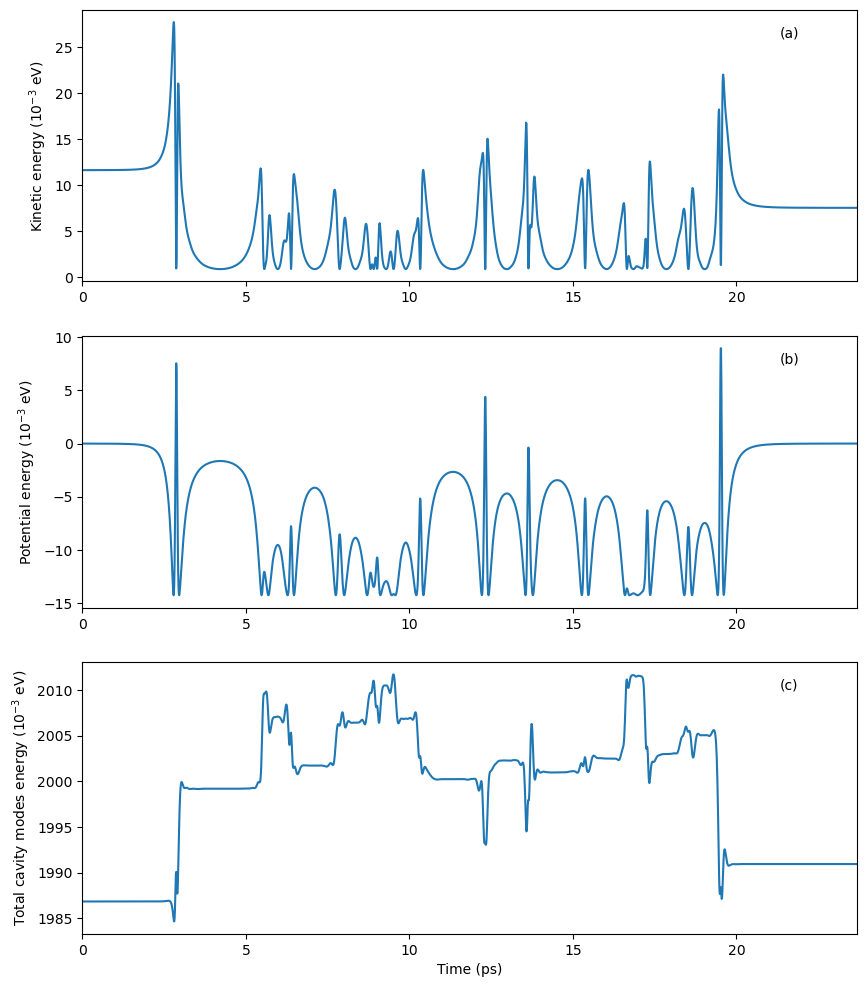

In [32]:
from calculator.function import LJ_potential

coltime = np.array(get_colliding_time(atoms, 0))

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,0]
r_xe = np.array(atoms.trajectory['r'])[:,1]

v_ar = np.array(atoms.trajectory['r_dot'])[:,0]
v_xe = np.array(atoms.trajectory['r_dot'])[:,1]

t = np.array(atoms.trajectory['t'])

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem, hem)

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[0],t[-1])
ax[1].set_xlim(t[0],t[-1])
ax[2].set_xlim(tem[0],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig('figure/manuscript/energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')